# k-Means Clustering

We've already explored dimensionality reduction algorithms in previous discussions. Here we will move on to another class of unsupervised models: clustering algorithms. Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

We will discuss what it perhaps the simplest clustering algorithm to understand: _k-means_.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## Introducing k-Means

The k-means algorithms searches fro a pre-determined number of clusters within a unlabeled dataset. To do this, the algorithm uses a simple conception of what the optimal clustering looks like:

- The cluster center is the arithmetic mean of all the points that belong to the cluster.
- Each point is closer to its own cluster than to other clusters.

These assumptions are the basis of the k-means model. To see it in action, let's generate a two-dimensional dataset containing four distinct blobs:

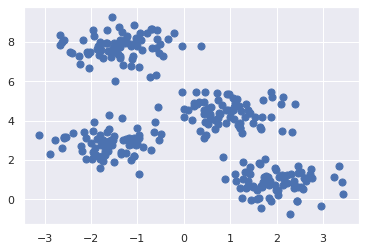

In [2]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

Even without the labels as colors, we can relatively easily pick up the four distinct clusters. The k-means algorithm can do this automatically, so let's take a look:

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

With the model fit and predictions at hand, we can visualize the results by plotting the data colored by these predicted labels. We will also plot the cluster centers determined by the estimator:

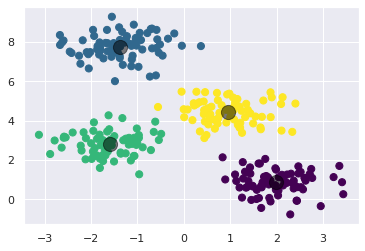

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

We can see that the algorithm assigns points to clusters very similarly to how a human would probably do by eye. The number of possible combinations of cluster assignments is exponential in the number of data points, so an exhaustive search would be very costly. Fortunately, such an exhaustive search is not necessary at all, thanks to an iterative approach known as _expectation-maximization_.

## k-Means Algorithm: Expectation-Maximization

Expectation-Maximization(E-M) is a powerful algorithm that comes up in a variety of contexts within data science. In the particular case of the k-Means algorithm, the expectation-maximization approach consists of the following:

1. Guess some cluster centers
2. Repeat until converged
    1. _E-Step_: assign points to the nearest cluster center
    2. _E-Step_: set the cluster centers to the mean
    
The "E-step" or "Expectation step" involves updating our expectation of which cluster each point belongs to. The "M-step" or "Maximization step" involves maximizing some fitness function that defines the location of the cluster centers (in this case, this is accomplished by taking a mean of the data in each cluster).

This algorithm can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm in the following figure, in which it converges in just three iterations:

![k-Means Example](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.11-expectation-maximization.png)

To show the simplicity of this algorithm, we can implement it in just a few lines of code:

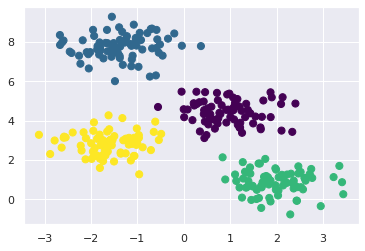

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Caveats of k-means

We need to be aware of a few issues when using k-means.

#### The globally optimal result may not be achieved

The E-M procedure is guaranteed to improve the result in each step, but it does not assure that it will lead to the _global_ best solution. For instance, with a different random seed in our sample procedure, the particular initial conditions can lead to poor results:

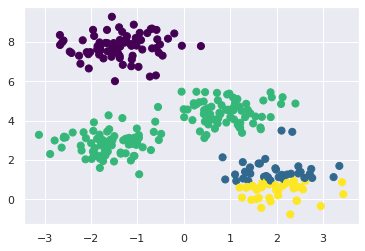

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Although the E-M approach has converged, it did not converge to a globally optimal configuration. For this reason, it is common to run the algorithm for multiple initial conditions (as Scikit-Learn does by default).

#### The number of clusters must be selected beforehand

Another challenge we have to face is that with k-means, we must tell the algorithm how many clusters we expect. If we provide a poor choice for $k$, we will get poor results:

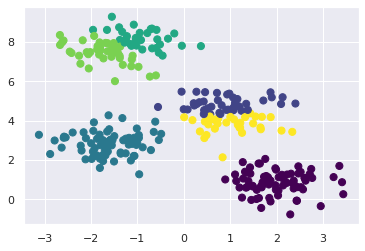

In [7]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### k-means is limited to linear cluster boundaries

The fundamental assumptions that model k-means means that the algorithm will often be rendered ineffective for complicated cluster geometries. In particular, the boundaries between k-means clusters will always be linear. Consider the following data:

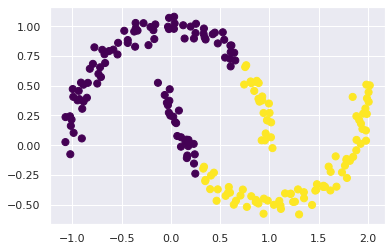

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### k-means can be slow for large numbers of samples

The algorithm can be very slow as the number of samples grows, since each iteration must access every point in the dataset. The requirement to use all the data can be relaxed: this is the idea behind batch-based k-means (one form of which is implemented in `sklearn.cluster.MiniBatchKmeans`).

## Examples

Knowing these limitations of the algorithm, we can use it to our advantage in various situations. Let's look at a couple of examples.

### Example 1: k-means on digits

Here we will use k-means to identify similar digits _without using the original label information_. We will start by loading the digits and then finding the clusters with `KMeans`:

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [10]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

We can see that the result is 10 clusters in 64 dimensions. Let's see what these cluster centers (which are 64-dimensional points themselves) look like:

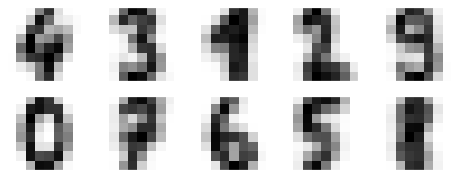

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We can see that even without the labels, `KMeans` was able to find clusters whose centers are somewhat recognizable digits.

Because k-means known nothing about the identify of each cluster, the labels assigned may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:

In [12]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

We can now check how well `KMeans` was able to find similar digits within the data:

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

With just this simple algorithm, and without any _a priori_ information, we were able discover the correct grouping for 80% of the input digits! Let's take a look at the confusion matrix:

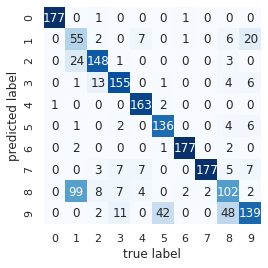

In [14]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

We can push this even farther using the t-SNE algorithm to pre-process the data before performing the clustering. t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters. Let's see well this improves our results:

In [15]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9371174179187535

That's almost 94% classification accuracy _without the labels_! 

### Example 2: k-means for color compression

An interesting application of clustering is in color compression within images. In a regular image, many pixels have similar or even identical colors. Consider the image shown in the following figure:

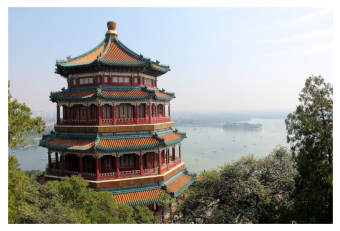

In [16]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

We will reshape the data to `[n_samples, n_features]`, and rescale the colors so that they lie between 0 and 1:

In [17]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Let's visualize these pixels in this color space, using a subset of 10000 pixels for efficiency:

In [18]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

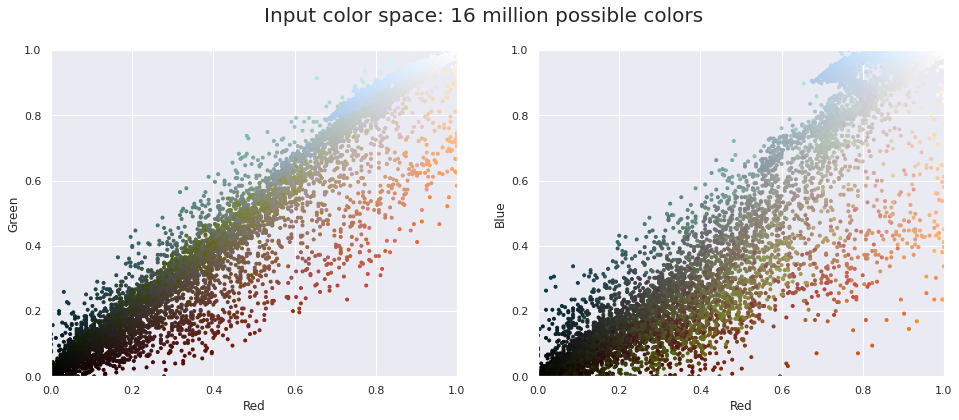

In [19]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Let's now reduce these 16 million colors to just 16, using k-means clustering acrros the pixel space. Because the dataset is very large, we will use the mini batch k-means for efficiency:

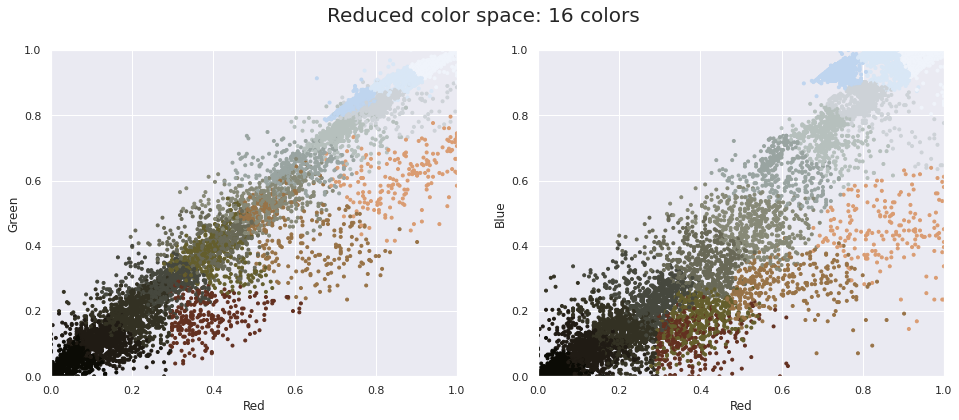

In [20]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

This results in a re-coloring of the original pixels, where each pixel is assigned to the color of its closest cluster center. We can more clearly visualize the effects of this plotting these new colors in the image:

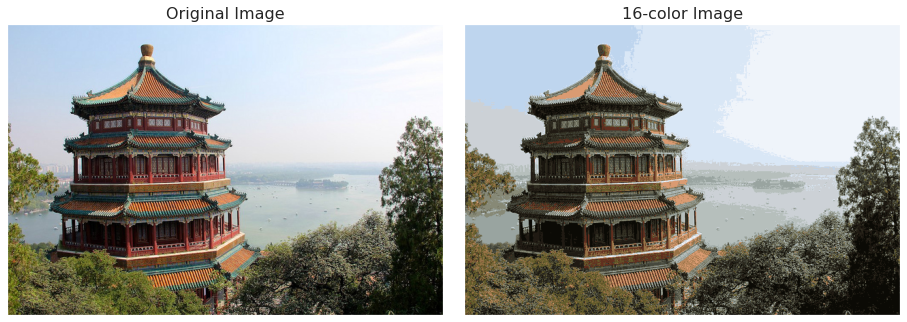

In [21]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

We certainly lost some detail in the rightmost panel, but the image is still very similar, while achieving a compression factor of around 1 million.